## ExMAS
> Exact Matching of Attractive Shared rides (ExMAS) for system-wide strategic evaluations
> 
> Kucharski R., Cats O. ,_Transportation Research Part: B_, 2020

---
#### Importing networks



In [1]:
import os
cwd = os.getcwd()

In [2]:
os.chdir(os.path.join(cwd,'../..'))
import ExMAS.main
import ExMAS.utils

In [166]:
import os
import sys
# utils
import json
import random
import math
import logging
from dotmap import DotMap
# side packages
import pandas as pd
import osmnx as ox
import networkx as nx
import numpy as np
from osmnx.distance import get_nearest_node
import matplotlib.pyplot as plt

-----
## Import network and compute skim for a city
Here we download city graph, compute the skims and save to graphml and csvs
for future use in ExMAS

It:
* loads data for `params.city` 
* computes the skim, 
* saves the files into `params.paths.skim` and `params.paths.G`

#### Download single city and save skims

In [11]:
params = ExMAS.utils.get_config('ExMAS/data/configs/corona.json')

In [12]:
from ExMAS.utils import inData as inData

In [90]:
import seaborn as sns
pal = sns.color_palette("tab10")
pal

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

In [21]:
inData = ExMAS.utils.load_G(inData, params, stats = True) # download the graph and compute the skim

In [112]:
inData = ExMAS.utils.generate_demand(inData, params)

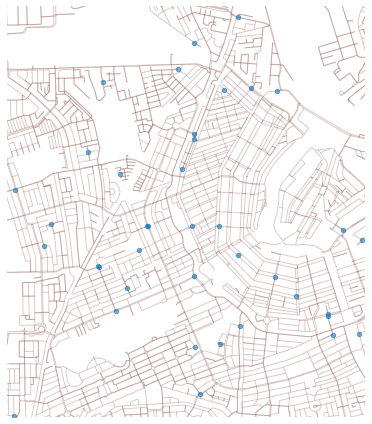

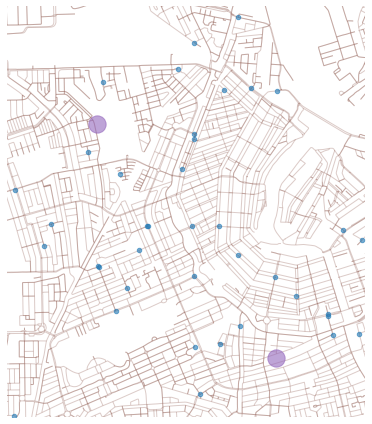

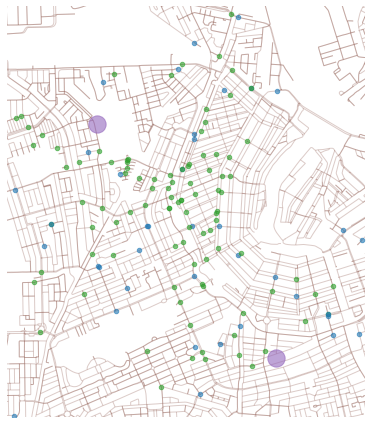

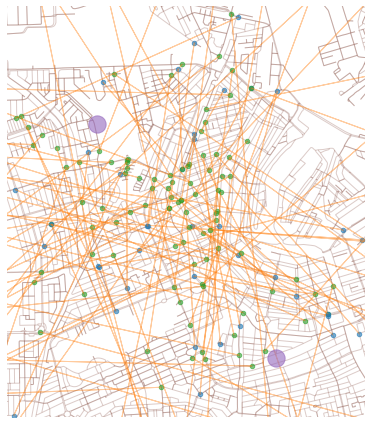

In [117]:
def plot_demand_poly(inData, _params, t0=None, vehicles=False, s=20, center = False, destinations = False, arrow = False):
    x = inData.G.nodes[inData.stats['center']]['x']
    y = inData.G.nodes[inData.stats['center']]['y']
    #bbox = (Y.max() + deltaY, Y.min() - deltaY, X.max() + deltaX, X.min() - deltaX)
    delta = 0.03
    bbox = [y+delta*0.7, y-delta*0.7,
            x+delta, x-delta]
    plt.rcParams['figure.figsize'] = [12, 4]
#     if t0 is None:
#         t0 = inData.requests.treq.mean()

#     # plot osmnx graph, its center, scattered nodes of requests origins and destinations
#     # plots requests temporal distribution
#     fig, ax = plt.subplots(1, 3)
#     ((t0 - inData.requests.treq) / np.timedelta64(1, 'h')).plot.kde(title='Temporal distribution', ax=ax[0])
#     (inData.requests.ttrav / np.timedelta64(1, 'm')).plot(kind='hist', title='Trips travel times [min]', ax=ax[1])
#     inData.requests.dist.plot(kind='hist', title='Trips distance [m]', ax=ax[2])
#     # (inData.requests.ttrav / np.timedelta64(1, 'm')).describe().to_frame().T
#     plt.tight_layout()
#     plt.show()
    fig, ax = ox.plot_graph(inData.G, node_size=0, edge_linewidth=1, edge_alpha = 0.3,
                            show=False, close=False, bbox = bbox,
                            edge_color=pal[5], bgcolor = 'white', figsize = (6,6))
    for _, r in inData.requests.iterrows():
        if _ % 3 ==0:
            ax.scatter(inData.G.nodes[r.origin]['x'], inData.G.nodes[r.origin]['y'], color=pal[0], alpha = 0.6, s=s, marker='o')
            if destinations:
            
                ax.scatter(inData.G.nodes[r.destination]['x'], inData.G.nodes[r.destination]['y'], color=pal[2], alpha = 0.6, s=s, marker='o')
                if arrow:
                    ax.arrow(inData.G.nodes[r.origin]['x'], inData.G.nodes[r.origin]['y'], 
                             inData.G.nodes[r.destination]['x']-inData.G.nodes[r.origin]['x'], inData.G.nodes[r.destination]['y']-inData.G.nodes[r.origin]['y'], 
                             width = 0.000001, alpha = 0.4, color = pal[1])
                             #head_width=0, head_length=0, fc='k', ec='k', head_starts_at_zero = True)
    if vehicles:
        for _, r in inData.vehicles.iterrows():
            ax.scatter(inData.G.nodes[r.pos]['x'], inData.G.nodes[r.pos]['y'], c='blue', s=s, marker='x')
    if center:
        ax.scatter(inData.G.nodes[inData.stats['center']]['x']-delta/2, inData.G.nodes[inData.stats['center']]['y']+delta*0.3, alpha = 0.6, color=pal[4],
               s=15 * s, marker='o')
        ax.scatter(inData.G.nodes[inData.stats['center']]['x']+delta/2, inData.G.nodes[inData.stats['center']]['y']-delta*0.5, alpha = 0.6, color=pal[4],
               s=15 * s, marker='o')
    
        # for i in range(_params.nCenters):
        #     ax.scatter(inData.G.nodes[inData.centers[i]]['x'], inData.G.nodes[inData.centers[i]]['y'], c='blue', s=50 * s,
        #                marker='x')

    plt.tight_layout()
    #plt.title(
    #    'Demand in {} with origins marked in green, destinations in orange and vehicles in blue'.format(_params.city))
    plt.show()
plot_demand_poly(inData,params)
plot_demand_poly(inData,params,center = True)
plot_demand_poly(inData,params,center = True, destinations = True)
plot_demand_poly(inData,params,center = True, destinations = True, arrow = True)

----

#### Some osmnx tutorial
we import graphs with `osmnx` 

for different cities, change the string

--- 
### 1. Import driveable network for `Delft`

In [8]:
#small imports
import sys
import random
import time
import pprint
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [16, 16]

In [9]:
#big imports
import osmnx as ox #OSM download and parse
import pandas as pd 
import networkx as nx #graphs

In [10]:
G = ox.graph_from_place('Delft, Netherlands', network_type='drive')

In [5]:
from ExMAS.utils import inData as inData

In [6]:
inData = ExMAS.utils.load_G(inData, params, stats=True)  # download the graph

FileNotFoundError: [Errno 2] No such file or directory: '/Users/rkucharski/Documents/GitHub/MaaSSim_sketches/data/graphs/Nootdorp.graphml'

### 2. Plot it

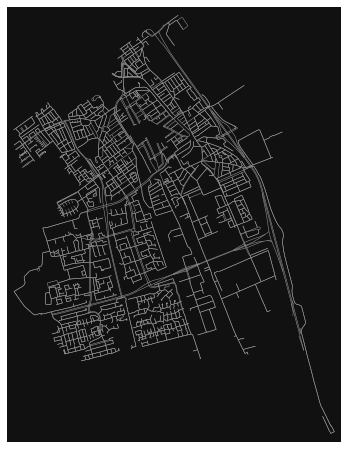

In [11]:
_ = ox.plot_graph(G,node_size=0, edge_linewidth=0.5)

#### * Network stats

In [12]:
pprint.pprint(ox.basic_stats(G))

{'circuity_avg': 1.0871747281218724,
 'clean_intersection_count': None,
 'clean_intersection_density_km': None,
 'edge_density_km': None,
 'edge_length_avg': 89.36920830130656,
 'edge_length_total': 465077.35999999935,
 'intersection_count': 1786,
 'intersection_density_km': None,
 'k_avg': 4.681961313540261,
 'm': 5204,
 'n': 2223,
 'node_density_km': None,
 'self_loop_proportion': 0.00595695618754804,
 'street_density_km': None,
 'street_length_avg': 91.86606975978967,
 'street_length_total': 279180.9860000008,
 'street_segments_count': 3039,
 'streets_per_node_avg': 2.736392262708052,
 'streets_per_node_counts': {0: 0, 1: 437, 2: 63, 3: 1384, 4: 327, 5: 12},
 'streets_per_node_proportion': {0: 0.0,
                                 1: 0.19658119658119658,
                                 2: 0.02834008097165992,
                                 3: 0.6225820962663068,
                                 4: 0.14709851551956815,
                                 5: 0.005398110661268556}}


### 3. Graph data

In [13]:
G.get_edge_data(1501364225, 1402613311)

{0: {'osmid': 136852791,
  'oneway': True,
  'lanes': '1',
  'name': 'Brasserskade',
  'highway': 'unclassified',
  'maxspeed': '50',
  'length': 14.888}}

#### DataFrame and .csv export

In [14]:
df = nx.to_pandas_edgelist(G)
df.to_csv('Delft.csv')
df.head()

,source,target,name,highway,osmid,bridge,ref,tunnel,junction,access,lanes,geometry,width,maxspeed,length,oneway
0,1501364225,1402613311,Brasserskade,unclassified,136852791,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,50,14.888,True
1,1501364225,1501364218,Brasserskade,secondary,136852797,NaN,NaN,NaN,NaN,NaN,3,"LINESTRING (4.362211 52.0275607, 4.3622056 52....",NaN,50,86.030,True
2,1269112834,626146739,Pierre van Hauwelaan,tertiary,"[131635875, 812784588, 131635877]",yes,NaN,NaN,NaN,NaN,1,"LINESTRING (4.3500691 51.9964222, 4.3492182 51...",NaN,50,229.396,True
3,44875780,44875431,Vernieuwde Boogerd,living_street,7538524,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15,22.932,False
4,44875780,1371031431,Koningsplein,living_street,364437785,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15,55.130,False


### 4. Graph searches 

In [15]:
node_list = list(G.nodes)
o = random.choice(node_list)
d = random.choice(node_list)

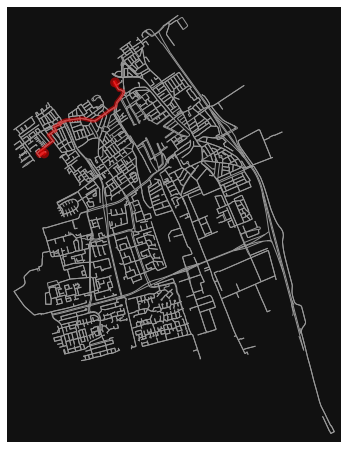

In [16]:
# find the route between these nodes then plot it
route = nx.shortest_path(G, o, d, weight='length')
fig, ax = ox.plot_graph_route(G, route, node_size=0)

In [17]:
print("Shorthest path from node {} to node {} distance: {}m".format(o,d,nx.shortest_path_length(G, o, d, weight='length')))

Shorthest path from node 3166286455 to node 7229895343 distance: 2491.2790000000005m


### 5. Skim matrices

In [18]:
skim = dict(nx.all_pairs_dijkstra_path_length(G, weight = 'length')) # may take some time

In [19]:
o = random.choice(node_list)
d = random.choice(node_list)
print("From node {} to node {} distance: {}m".format(o,d,round(skim[o][d])))

From node 1571087635 to node 1570983098 distance: 1837m


-------------
Rafal Kucharski, 2019, Delft, r.m.kucharski@tudelft.nl